In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
TAVILY_API_KEY

'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'

In [2]:
from langchain_tavily import TavilySearch
tool = TavilySearch(api_key=TAVILY_API_KEY)
tools = [tool]
tool.invoke("Whay is hydrogen is flamable?")

{'query': 'Whay is hydrogen is flamable?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.reddit.com/r/explainlikeimfive/comments/118lq04/eli5_what_makes_some_elements_flammable_while/',
   'title': "What makes some elements flammable while others aren't? Why is ...",
   'content': 'Hydrogen is very flammable because its molecules contain only two atoms, which makes it very reactive and able to combine with oxygen to produce',
   'score': 0.81347597,
   'raw_content': None},
  {'url': 'https://www.aiche.org/sites/default/files/docs/pages/the_elemental_-_hydrogen_flammability.pdf',
   'title': '[PDF] Hydrogen Flammability - AIChE',
   'content': "View in Web Browser Hydrogen Flammability All fuels have a unique flammable range, which is the minimum and maximum concentration in air necessary for combustion to occur. Hydrogen's flammability range (between 4% and 75% in air) is extensive compared to other fuels, as shown below. Along with it

### Agent with tools

In [5]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
import os
from dotenv import load_dotenv
load_dotenv()

# Define the Agent State
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]

TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
GOOGLE_API_KEY = os.getenv("GEMINI_API_KEY")

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp", api_key=GOOGLE_API_KEY)

# Create a proper tool function
@tool 
def web_search(query: str) -> str:
    """Search the web for current information and recent events.
    
    Args:
        query: The search query string
        
    Returns:
        Search results as a string
    """
    search = TavilySearchResults(api_key=TAVILY_API_KEY, max_results=30)
    results = search.invoke(query)
    
    # Format the results nicely
    formatted_results = []
    for result in results:
        title = result.get('title', 'No title')
        content = result.get('content', 'No content')
        url = result.get('url', 'No URL')
        formatted_results.append(f"Title: {title}\nContent: {content}\nURL: {url}\n")
    
    return "\n---\n".join(formatted_results)

# Define tools list
tools = [web_search]

# Create tool node
from langgraph.prebuilt import ToolNode
tool_node = ToolNode(tools)

# Create Agent function
from langchain_core.prompts import ChatPromptTemplate

def chatbot(state: AgentState):
    '''Agent node that decides what to do'''
    
    # Create prompt that guides the agent
    prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a helpful assistant with extensive knowledge about science, history, and general topics.

        ONLY use the web_search tool when users ask about:
        - Current events, recent news, or anything happening "now" or "recently"
        - Real-time information (stock prices, weather, sports scores)
        - Recent meetings, conferences, or political events
        - Latest developments or updates (within the last few months)
        - Specific dates or events after 2024
        
        DO NOT use web_search for:
        - Basic scientific facts (like properties of elements, atoms, chemistry)
        - Historical information
        - General knowledge questions
        - Mathematical or logical problems
        - Definitions or explanations of concepts
        
        For these topics, use your built-in knowledge to provide accurate answers.
        Be conversational and helpful!"""),
        ("placeholder", "{messages}")
    ])

    # Bind tools to the LLM
    chain = prompt | llm.bind_tools(tools)
    
    # Invoke with the full message history
    response = chain.invoke({"messages": state["messages"]})
    
    return {"messages": [response]}

def should_continue(state: AgentState):
    """Decides what to do next"""
    messages = state['messages']
    last_message = messages[-1]
    
    # If the AI wants to use a tool, go to tools
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "tools"
    # Otherwise we're done
    return END

# Build the graph
graph_builder = StateGraph(AgentState)

# Add nodes
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

# Set entry point
graph_builder.add_edge(START, "chatbot")

# Add conditional edges
graph_builder.add_conditional_edges(
    "chatbot", 
    should_continue,
    {
        "tools": "tools",
        END: END
    }
)

# After using tools, go back to chatbot
graph_builder.add_edge("tools", "chatbot")

# Compile the graph
graph = graph_builder.compile()

# Example interaction
if __name__ == "__main__":
    response = graph.invoke({
        "messages": [{"role": "user", "content": "What discussions went on between Prime Minister Modi and putin during there recent SCO meeting?"}]
    })
    
    # Print the final response
    print(response["messages"][-1].content)



# if __name__ == "__main__":
#     response = graph.invoke({
#         "messages": [{"role": "user", "content": "How many electorns inside Hydrogen atom? Why hydrgen is explosive?"}]
#     })
    
#     # Print the final response
#     print(response["messages"][-1].content)

Based on the information I found, here's a summary of the discussions between Prime Minister Modi and President Putin during their recent SCO meeting:

*   **Bilateral Cooperation:** They discussed ways to deepen cooperation in various sectors, including trade, fertilizers, space, security, and culture.
*   **Regional and Global Developments:** They exchanged views on regional and global developments, including the peaceful resolution of the conflict in Ukraine. Modi welcomed initiatives aimed at halting the conflict and called for constructive steps to establish peace.
*   **Strategic Partnership:** They reaffirmed their commitment to strengthening the "special and privileged strategic partnership" between India and Russia, emphasizing its importance for regional and global stability.
*   **Ukraine Conflict:** Modi expressed hope that both sides would move forward to end the war soon.
*   **Upcoming Summit:** Modi mentioned he was looking forward to receiving Putin in India for the 23

In [3]:
# Example interaction
if __name__ == "__main__":
    response = graph.invoke({
        "messages": [{"role": "user", "content": "How many electorns inside Hydrogen atom? Why hydrgen is explosive?"}]
    })
    
    # Print the final response
    print(response["messages"][-1].content)

A neutral hydrogen atom has **one** electron.

Hydrogen is explosive due to these reasons:

*   **Flammability:** Hydrogen gas (H2) is highly flammable and requires very little energy to ignite when mixed with air.
*   **Wide flammability range:** Hydrogen can form explosive mixtures with air in a wide range of concentrations (4-74%).
*   **Reactivity with oxygen:** Hydrogen reacts vigorously with oxygen, releasing a large amount of energy in the process, which causes explosions.


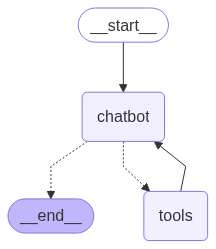

In [6]:
from IPython.display import Image

Image(graph.get_graph().draw_mermaid_png())

## Adding memory to the agent

Right now, our agent:

Handles one-shot queries.

Keeps messages inside a single run, but forgets after execution.

Adding memory means:

The graph can remember past conversations across turns.

User doesn’t have to repeat context every time.

The agent feels more “chat-like” instead of “Q&A only.”


In [ ]:
"""1. The Problem Without Memory

Example with your current code:

User: Who won the 2022 FIFA World Cup?
Agent: Argentina won the 2022 FIFA World Cup.
User: Where was it held?
Agent: Sorry, I don’t know what you’re referring to.

👉 The agent forgets that the previous topic was the World Cup.
"""

In [ ]:
"""2. The Idea of Memory

We need to persist conversation state across multiple invocations.

LangGraph lets us:

Store checkpoints → snapshots of agent state.

Use a memory backend → like SQLite, Postgres, Redis, or even in-memory dicts.

Reload conversation history automatically.
"""

In [ ]:
## Add Checkpoint Saver

## LangGraph provides a MemorySaver:

from langgraph.checkpoint.memory import MemorySaver, InMemorySaver
memory = MemorySaver()
'''AgentStateOnly use InMemorySaver for debugging or testing purposes.
For production use cases we recommend installing langgraph-checkpoint-postgres and using PostgresSaver / AsyncPostgresSaver.
If you are using the LangGraph Platform, no checkpointer needs to be specified. The correct managed checkpointer will be used automatically.
'''

'AgentStateOnly use InMemorySaver for debugging or testing purposes.\nFor production use cases we recommend installing langgraph-checkpoint-postgres and using PostgresSaver / AsyncPostgresSaver.\nIf you are using the LangGraph Platform, no checkpointer needs to be specified. The correct managed checkpointer will be used automatically.\n'

In [ ]:
# Update Graph to Use Memory

# When compiling your graph, attach the memory:

graph = graph_builder.compile(checkpointer=memory)

# Now the graph will automatically save state at every step and reload it for the next user input.

In [ ]:
# Interact with your chatbot¶
# Now you can interact with your bot!

# Pick a thread to use as the key for this conversation.

config = {"configurable": {"thread_id": "1"}}

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

In [ ]:
# Example Flow with Memory

"""
User: Who won the 2022 FIFA World Cup?
Agent: Argentina won the 2022 FIFA World Cup.
User: Where was it held?
Agent: It was held in Qatar.

"""

In [10]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langgraph.checkpoint.memory import InMemorySaver
import os
from dotenv import load_dotenv
load_dotenv()

# Define the Agent State
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]

TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
GOOGLE_API_KEY = os.getenv("GEMINI_API_KEY")

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp", api_key=GOOGLE_API_KEY)
memory = InMemorySaver()
# Create a proper tool function
@tool 
def web_search(query: str) -> str:
    """Search the web for current information and recent events.
    
    Args:
        query: The search query string
        
    Returns:
        Search results as a string
    """
    search = TavilySearchResults(api_key=TAVILY_API_KEY, max_results=30)
    results = search.invoke(query)
    
    # Format the results nicely
    formatted_results = []
    for result in results:
        title = result.get('title', 'No title')
        content = result.get('content', 'No content')
        url = result.get('url', 'No URL')
        formatted_results.append(f"Title: {title}\nContent: {content}\nURL: {url}\n")
    
    return "\n---\n".join(formatted_results)

# Define tools list
tools = [web_search]

# Create tool node
from langgraph.prebuilt import ToolNode
tool_node = ToolNode(tools)

# Create Agent function
from langchain_core.prompts import ChatPromptTemplate

def chatbot(state: AgentState):
    '''Agent node that decides what to do'''
    
    # Create prompt that guides the agent
    prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a helpful assistant with extensive knowledge about science, history, and general topics.

        ONLY use the web_search tool when users ask about:
        - Current events, recent news, or anything happening "now" or "recently"
        - Real-time information (stock prices, weather, sports scores)
        - Recent meetings, conferences, or political events
        - Latest developments or updates (within the last few months)
        - Specific dates or events after 2024
        
        DO NOT use web_search for:
        - Basic scientific facts (like properties of elements, atoms, chemistry)
        - Historical information
        - General knowledge questions
        - Mathematical or logical problems
        - Definitions or explanations of concepts
        
        For these topics, use your built-in knowledge to provide accurate answers.
        Be conversational and helpful!"""),
        ("placeholder", "{messages}")
    ])

    # Bind tools to the LLM
    chain = prompt | llm.bind_tools(tools)
    
    # Invoke with the full message history
    response = chain.invoke({"messages": state["messages"]})
    
    return {"messages": [response]}

def should_continue(state: AgentState):
    """Decides what to do next"""
    messages = state['messages']
    last_message = messages[-1]
    
    # If the AI wants to use a tool, go to tools
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "tools"
    # Otherwise we're done
    return END

# Build the graph
graph_builder = StateGraph(AgentState)

# Add nodes
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

# Set entry point
graph_builder.add_edge(START, "chatbot")

# Add conditional edges
graph_builder.add_conditional_edges(
    "chatbot", 
    should_continue,
    {
        "tools": "tools",
        END: END
    }
)

# After using tools, go back to chatbot
graph_builder.add_edge("tools", "chatbot")

# Compile the graph
graph = graph_builder.compile(checkpointer=memory)

# Example interaction
# if __name__ == "__main__":
#     response = graph.invoke({
#         "messages": [{"role": "user", "content": "What discussions went on between Prime Minister Modi and putin during there recent SCO meeting?"}]
#     })
    
#     # Print the final response
#     print(response["messages"][-1].content)

# thread = {"configurable": {"thread_id": "1"}}

# if __name__ == "__main__":
#     response = graph.invoke({
#         "messages": [{"role": "user", "content": "How many electorns inside Hydrogen atom? Why hydrgen is explosive?"}]
#     }, 
#     config= thread
#     )
    
#     # Print the final response
#     print(response["messages"][-1].content)

In [ ]:
'''
What is a Thread ID?

A thread = one conversation (like a chat session between a user and the agent).

The thread_id is just a unique identifier (string) that LangGraph uses to know which conversation memory to load and update.

👉 Think of it as the conversation ID in WhatsApp — every chat with a friend has a separate ID, so your chats don’t mix.
'''

In [11]:
thread = {"configurable": {"thread_id": "1"}}
response1  = graph.invoke({
        "messages": [{"role": "user", "content": "please provide me details about the heterocyclic compounds?"}]
    }, 
    config= thread
    )
    
    # Print the final response1 
print(response1["messages"][-1].content)

Heterocyclic compounds are organic compounds that contain a ring structure containing at least one atom other than carbon (C) as a member of the ring. These non-carbon atoms are called heteroatoms, and the most common ones are nitrogen (N), oxygen (O), and sulfur (S). Heterocyclic compounds can be simple aromatic rings or non-aromatic rings.

Here's a more detailed breakdown:

*   **Ring Structure:** The defining feature is the presence of a ring. This ring can be of various sizes (3-membered, 4-membered, 5-membered, 6-membered, etc.) and can be monocyclic (a single ring) or polycyclic (multiple rings fused together).

*   **Heteroatoms:** The presence of one or more heteroatoms (N, O, S, and less commonly other elements like phosphorus or boron) within the ring is crucial. These heteroatoms replace carbon atoms in the ring structure.

*   **Aromatic vs. Non-aromatic:** Heterocyclic compounds can be aromatic (exhibiting special stability due to a delocalized pi electron system, like be

In [12]:
response2  = graph.invoke({
        "messages": [{"role": "user", "content": "is there any explosives in these compounds?"}]
    }, 
    config= thread
    )
    
    # Print the final response1 
print(response2["messages"][-1].content)

While many heterocyclic compounds are stable and essential for life, some can be part of explosive materials or used as precursors in their synthesis. The presence of a heterocyclic ring alone doesn't automatically make a compound explosive. Explosivity depends on the overall molecular structure and the presence of specific functional groups that can lead to rapid, exothermic decomposition.

Here's a more nuanced explanation:

*   **Nitro Groups (-NO2):** The most common way to make a heterocyclic compound explosive is to introduce nitro groups (-NO2) onto the ring. Nitro groups are highly energetic and can cause rapid decomposition. Examples include:
    *   **Nitropyrazoles:** These can be explosive, with the degree of explosivity depending on the number and position of the nitro groups.
    *   **Nitroimidazoles:** Similar to nitropyrazoles, these can also be explosive.
    *   **Nitrofurans:** Some nitrofurans are known to be explosive.

*   **Azides (-N3):** Attaching azide groups

In [13]:
response3  = graph.invoke({
        "messages": [{"role": "user", "content": "Can we add phosporus related chemicals to this ring?"}]
    }, 
    config= thread
    )
    
    # Print the final response1 
print(response3["messages"][-1].content)

Yes, you can definitely incorporate phosphorus-containing chemicals into heterocyclic rings. Phosphorus heterocycles are a well-established area of chemistry. The way you add phosphorus and the resulting structure depends on the specific phosphorus compound and the desired properties. Here are some general ways phosphorus can be incorporated:

*   **Direct Incorporation into the Ring:** Phosphorus can directly replace a carbon or other heteroatom in the ring structure itself, forming a phosphorus-containing heterocycle. For example, you can have rings containing P, N, and C atoms. These are often called phosphacycles.

*   **Phosphorus-Containing Substituents:** Phosphorus-containing groups can be attached as substituents to an existing heterocyclic ring. Common examples include:
    *   **Phosphine Groups (-PR2):** where R can be alkyl, aryl, or other groups.
    *   **Phosphine Oxide Groups (-P(O)R2):**
    *   **Phosphonate Groups (-PO(OR)2):**
    *   **Phosphonium Salts ([PR4]+ X-

### How to Manage Thread IDs in Production

In [ ]:
'''In production, you need a strategy for generating & managing these IDs:

Option A. Use User ID

If each user logs in, use their user ID or email.

Example: "thread_id": "user_789".

Memory sticks with the user across sessions.

Option B. Use Session ID

If you want memory only during one session/tab, generate a random UUID at session start.

Example: "thread_id": "c2f9d5d2-6c81-4a0a-9a33".

When session ends, memory is discarded.

Option C. Use Both

Combine user ID + session ID.

Example: "thread_id": "user_789_session_001".

Lets you have multiple independent conversations per user.

🛠️ 5. Where to Store Thread IDs?

Frontend apps (React/Flutter/web) → store in cookies, localStorage, or sessionStorage.

Backend APIs (FastAPI/Django) → pass thread_id in request headers or body.

Databases → map thread_id → conversation logs, so you can reload later.
'''

### Human-in-the-Loop

In [2]:
from typing import Annotated, List, Dict, Any
from typing_extensions import TypedDict
from datetime import datetime, timedelta
import uuid, json, time, os

from dotenv import load_dotenv
load_dotenv()

# LangGraph & LangChain imports
from langgraph.graph import StateGraph, END, START
from langgraph.graph.message import add_messages, AnyMessage
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import InMemorySaver

#LLM and tools
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_core.prompts import ChatPromptTemplate

# Small helper for date parsing
from dateutil import parser as dateparser


# Configure API keys
GEMINI_API_KEY = os.getenv('GEMINI_API_KEY')
TAVILY_API_KEY = os.getenv('TAVILY_API_KEY')

# Basic sanity checks 
if not GEMINI_API_KEY:
    print("WARNING: GEMINI_API_KEY not set. Set GEMINI_API_KEY in environment or .env to use the LLM.")
if not TAVILY_API_KEY:
    print("WARNING: TAVILY_API_KEY not set. Web search tool will fail without it.")


# ----------------------------
# Agent State
# ----------------------------
class AgentState(TypedDict):
    """
    AgentState: conversation memory shape stored by the graph.

    messages: list of messages (user/assistant/tool) - langgraph's add_messages decorator manages appending.
    """

    messages: Annotated[List[AnyMessage], add_messages]


# ----------------------------
# In-memory booking store (demo)
# ----------------------------

# For the demo we store tentative & confirmed bookings in a dict keyed by thread_id.
# Production: persistent DB (Postgres/Redis) + transactional semantics.

_bookings_store: Dict[str, List[Dict[str, Any]]] = {}

# ----------------------------
# Utility functions
# ----------------------------
def make_thread_id() -> str:
    '''Create a new unique thread id (UUID4).'''
    return str(uuid. uuid4())

def parse_date_safe(date_str: str) -> datetime:
    '''Try to parse a date string robustly using dateutil; raise ValueError on failure.'''
    if not date_str or not isinstance(date_str, str):
        raise ValueError("Invalid date input.")
    # Accept natural language like "tomorrow" or ISO dates
    parsed = dateparser.parse(date_str, fuzzy=True)
    if not parsed:
        raise ValueError(f"Could not parse date: {date_str}")
    return parsed

def sanitize_location(loc: str) -> str:
    """Simple sanitization of location strings to avoid injection in mock tools."""
    return loc.strip()

# ----------------------------
# Tools Definitions
# ----------------------------
@tool
def web_search(query: str) -> str:
    """
    Tool: web_search
    - Uses TavilySearchResults to fetch top results for a query and returns a summarized string.

    Returns:
        A string with formatted search results (title, snippet, url) joined.
    """
    # Defensive programming: fail gracefully if no API key
    if not TAVILY_API_KEY:
        return "ERROR: TAVILY_API_KEY not configured."

    try:
        search = TavilySearchResults(api_key=TAVILY_API_KEY, max_results=5)
        results = search.invoke(query)
    except Exception as e:
        return f"ERROR: web_search failed: {e}"

    formatted = []
    for r in results:
        title = r.get("title", "No title")
        snippet = r.get("content") or r.get("snippet") or ""
        url = r.get("url", "")
        formatted.append(f"Title: {title}\nSnippet: {snippet}\nURL: {url}")
    return "\n\n---\n\n".join(formatted) if formatted else "No results found."


@tool
def check_availability(origin: str, destination: str, depart_date: str) -> str:
    """
    Tool: check_availability (mock)
    - Checks whether seats are available on the requested route+date.
    - For demo, availability logic is simplified.

    Returns:
        JSON string describing availability.
    """
    try:
        depart_dt = parse_date_safe(depart_date)
    except Exception as e:
        return json.dumps({"error": f"Invalid date: {e}"})

    origin = sanitize_location(origin)
    destination = sanitize_location(destination)

    # Mock logic: if date is within next 365 days and origin != destination -> available
    days_until = (depart_dt.date() - datetime.utcnow().date()).days
    if origin.lower() == destination.lower():
        return json.dumps({"available": False, "reason": "Origin and destination are the same."})
    if days_until < 0:
        return json.dumps({"available": False, "reason": "Date is in the past."})
    if days_until > 365:
        return json.dumps({"available": False, "reason": "Date too far in future for demo provider."})
    # Simulate limited capacity: if day-of-month is divisible by 13 -> low seats
    low_capacity = (depart_dt.day % 13 == 0)
    availability = {"available": True, "low_capacity": low_capacity, "days_until": days_until}
    return json.dumps(availability)

@tool
def make_booking(thread_id: str, user_name: str, origin: str, destination: str, depart_date: str) -> str:
    """
    Tool: make_booking (mock)
    - Creates a tentative booking and stores it in the in-memory _bookings_store.
    - Returns a JSON string with tentative booking details (including booking_id).
    - Note: this is 'tentative' and requires human approval in this demo.
    """
    try:
        depart_dt = parse_date_safe(depart_date)
    except Exception as e:
        return json.dumps({"error": f"Invalid date: {e}"})

    origin = sanitize_location(origin)
    destination = sanitize_location(destination)
    booking_id = str(uuid.uuid4())

    record = {
        "booking_id": booking_id,
        "user_name": user_name,
        "origin": origin,
        "destination": destination,
        "depart_date": depart_dt.isoformat(),
        "status": "tentative",
        "created_at": datetime.utcnow().isoformat(),
    }
    _bookings_store.setdefault(thread_id, []).append(record)

    # Return the tentative booking record
    return json.dumps({"result": "tentative_created", "booking": record})


@tool
def confirm_booking(thread_id: str, booking_id: str) -> str:
    """
    Tool: confirm_booking (mock)
    - Marks a tentative booking as 'confirmed'.
    - Returns JSON with confirmation details or an error message.
    """
    items = _bookings_store.get(thread_id, [])
    for item in items:
        if item["booking_id"] == booking_id:
            item["status"] = "confirmed"
            item["confirmed_at"] = datetime.utcnow().isoformat()
            return json.dumps({"result": "confirmed", "booking": item})
    return json.dumps({"error": "booking_id not found"})


@tool
def cancel_booking(thread_id: str, booking_id: str) -> str:
    """
    Tool: cancel_booking (mock)
    - Cancels a booking and records cancellation timestamp.
    """
    items = _bookings_store.get(thread_id, [])
    for item in items:
        if item["booking_id"] == booking_id:
            item["status"] = "cancelled"
            item["cancelled_at"] = datetime.utcnow().isoformat()
            return json.dumps({"result": "cancelled", "booking": item})
    return json.dumps({"error": "booking_id not found"})

# Tool list used by LLM
TOOLS = [web_search, check_availability, make_booking, confirm_booking, cancel_booking]

# ToolNode to execute tools within the LangGraph
tool_node = ToolNode(TOOLS)

# ----------------------------
# LLM Setup (Gemini)
# ----------------------------
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-001", api_key=GEMINI_API_KEY)

# ----------------------------
# Chatbot Node (decision maker)
# ----------------------------
def chatbot(state: AgentState):
    """
    Chatbot node: binds the available tools to the LLM and asks the LLM to respond based on the conversation history.

    Behavior:
    - The LLM is given a system prompt that describes available tools and expected behavior.
    - The chain returns a response. If the LLM decides to call a tool, the LLM's response will include a tool call in the structured format LangChain uses.
    """
    system_text = (
        "You are a travel assistant. You may use tools for:\n"
        "- web_search(query)\n"
        "- check_availability(origin, destination, depart_date)\n"
        "- make_booking(thread_id, user_name, origin, destination, depart_date)\n"
        "- confirm_booking(thread_id, booking_id)\n"
        "- cancel_booking(thread_id, booking_id)\n\n"
        "When you need up-to-date info, use web_search. When you want to create or confirm bookings, use the booking tools. "
        "Always be conversational and verify user details before booking. If you create a booking, it will be tentative and will require human approval."
    )

    # The prompt includes the conversation history injected as {messages}.
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_text),
        ("placeholder", "{messages}")
    ])

    # Bind tools to the LLM so it can generate tool call actions.
    chain = prompt | llm.bind_tools(TOOLS)

    # Invoke with full message history
    response = chain.invoke({"messages": state["messages"]})
    return {"messages": [response]}


# ----------------------------
# Router: decide next step after chatbot
# ----------------------------
def should_continue(state: AgentState):
    """
    Determine where to route after chatbot:
    - If LLM requested tool calls -> go to "tools" node
    - If LLM asked for human approval -> go to "human" node
    - Otherwise -> END
    """
    last_msg = state["messages"][-1]
    # Chat message may have tool_calls attribute if LLM emitted a tool call action
    if hasattr(last_msg, "tool_calls") and last_msg.tool_calls:
        return "tools"

    # Quick heuristic: if assistant asks for "approval" or contains "please approve booking" -> human review
    # In production, use structured signals (e.g., message.metadata or special tokens)
    txt = getattr(last_msg, "content", "")
    if isinstance(txt, str) and ("please approve" in txt.lower() or "awaiting approval" in txt.lower()):
        return "human"

    return END

# ----------------------------
# Human-in-the-loop node
# ----------------------------
def human_approval_node(state: AgentState):
    """
    Pause the graph and return the state for human review.
    In this demo, we perform a CLI-based approval: print the last assistant message + tentative booking(s),
    then ask the operator to approve / modify / reject.

    In production:
      - Persist paused state, notify a human via UI, email, or internal dashboard.
      - Human edits state and resumes the graph via API.
    """
    # Extract context for display
    messages = state["messages"]
    last_assistant = messages[-1] if messages else None

    # Show tentative bookings for this thread (if any)
    print("\n=== HUMAN REVIEW REQUIRED ===")
    print("Assistant message (awaiting approval):")
    print(getattr(last_assistant, "content", str(last_assistant)))
    print("\nTentative bookings in store for this thread:")
    # Last message may contain thread id - we expect thread_id in the config of invocation
    # Here we just show all entries; in production, map via thread id
    for tid, recs in _bookings_store.items():
        for r in recs:
            if r["status"] == "tentative":
                print(json.dumps(r, indent=2))
    print("=============================\n")

    # CLI prompt: approve or reject
    while True:
        resp = input("Human action (approve <booking_id> / reject <booking_id> / skip): ").strip()
        if resp.lower() == "skip":
            print("Skipping human approval (agent will continue but booking stays tentative).")
            return state
        parts = resp.split()
        if len(parts) == 2 and parts[0].lower() in {"approve", "reject"}:
            action, booking_id = parts[0].lower(), parts[1]
            if action == "approve":
                print(f"Approving booking {booking_id} ...")
                confirm_booking("", booking_id)  # thread_id not used in mock confirm; in prod supply correct thread
                print("Booking approved.")
            else:
                print(f"Cancelling booking {booking_id} ...")
                cancel_booking("", booking_id)
                print("Booking cancelled.")
            return state
        print("Invalid input. Example commands: 'approve <booking_id>', 'reject <booking_id>', or 'skip'.")


# ----------------------------
# Graph building & memory
# ----------------------------
graph_builder = StateGraph(AgentState)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)
graph_builder.add_node("human", human_approval_node)

# Start -> chatbot
graph_builder.add_edge(START, "chatbot")

# Conditional routing after chatbot
graph_builder.add_conditional_edges("chatbot", should_continue, {"tools": "tools", "human": "human", END: END})

# After tools, go back to chatbot for further reasoning
graph_builder.add_edge("tools", "chatbot")

# After human review, go back to chatbot
graph_builder.add_edge("human", "chatbot")

# Memory: small MemorySaver checkpointing; replace with SQLite/Postgres savers in production
memory = InMemorySaver()
graph = graph_builder.compile(checkpointer=memory)


# ----------------------------
# Helper: invoke with thread_id management
# ----------------------------
def invoke_with_thread(messages: List[Dict[str, str]], thread_id: str = None) -> Dict[str, Any]:
    """
    Helper to invoke the compiled graph with message history and thread_id.
    If thread_id is None, a new one is generated (stateless chat).
    """
    if thread_id is None:
        thread_id = make_thread_id()

    config = {"configurable": {"thread_id": thread_id}}
    # Graph.invoke expects the initial partial state; we provide messages and config
    result = graph.invoke({"messages": messages}, config=config)
    return {"thread_id": thread_id, "result": result}


# ----------------------------
# CLI demo
# ----------------------------
def cli_demo():
    print("Travel Booking Agent - Demo")
    print("Start a new conversation or resume an existing thread.")
    thread_id = None
    while True:
        if not thread_id:
            choice = input("\nCommands:\n [n] new conversation\n [r] resume with thread_id\n [q] quit\nChoose: ").strip().lower()
            if choice == "n":
                thread_id = None
            elif choice == "r":
                tid = input("Enter thread_id to resume: ").strip()
                if tid:
                    thread_id = tid
                else:
                    print("Invalid thread_id.")
                    continue
            elif choice == "q":
                print("Exiting.")
                return
            else:
                print("Unknown command.")
                continue

        user_input = input("\nYou: ").strip()
        if user_input.lower() in {"exit", "quit"}:
            print("Ending session.")
            return

        # Prepare message payload and call graph
        messages = [{"role": "user", "content": user_input}]
        out = invoke_with_thread(messages, thread_id)
        thread_id = out["thread_id"]
        result_state = out["result"]

        # Print the assistant's last message
        final_msg = result_state["messages"][-1]
        print("\nAssistant:", getattr(final_msg, "content", final_msg))

        print(f"[Thread ID: {thread_id}] (save this if you want to resume the conversation later)")

# Run CLI if executed
# if __name__ == "__main__":
#     cli_demo()

In [4]:
from IPython.display import Image
# Increase retries / delay (suggested by the error message)
Image(graph.get_graph().draw_mermaid_png(max_retries=5, retry_delay=2.0))

# Image(graph.get_graph().draw_mermaid_png())

ValueError: Failed to reach https://mermaid.ink/ API while trying to render your graph. Status code: 502.

To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`

In [1]:
from langgraph.prebuilt import ToolNode, tools_condition

import asyncio